#Transport in 1D

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this practical work session, we test the most simple lattice Boltzmann scheme $\DdQq{1}{2}$ on two classical hyperbolic scalar equations: the advection equation and the Burger's equation.

##The advection equation

The problem reads
$$\drondt u + c\drondx u = 0, \quad t>0, \quad x\in(0, 1),$$
where $c$ is a constant scalar (typically $c=1$).
Additional boundary and initial conditions will be given in the following.

The numerical simulation of this equation by a lattice Boltzmann scheme consists in the approximation of the solution on discret points of $(0,1)$ at discret instants.

The spatial mesh is defined by using a numpy array. To simplify, the mesh is supposed to be uniform.

####Question 1

First, import the package numpy and create the spatial mesh. One phantom cell has to be added at each edge of the domain for the treatment of the boundary conditions.

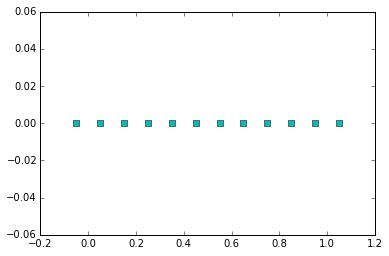

In [4]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

def mesh(N):
    xmin, xmax = 0., 1.
    dx = 1./N
    x = np.linspace(xmin-.5*dx, xmax+.5*dx, N+2)
    return x

x = mesh(10)
plt.plot(x, np.zeros(x.shape), 'sc')
plt.show()

To simulate this equation, we use the $\DdQq{1}{2}$ scheme given by

* two velocities $v_0=-1$, $v_1=1$, with associated distribution functions $\fk{0}$ and $\fk{1}$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* two moments $\mk{0}=\sum_{i=0}^1\fk{i}$ and $\mk{1}=\lambda \sum_{i=0}^1 v_i\fk{i}$ and their equilibrium values $\mke{0} = \mk{0}$, $\mke{1} = c\mk{0}$,
* a relaxation parameter $s$ lying in $[0,2]$.

In order to prepare the formalism of the package pyLBM, we introduce the two polynomials that define the moments: $P_0 = 1$ and $P_1=\lambda X$, such that
$$ \mk{k} = \sum_{i=0}^1 P_k(v_i) \fk{i}.$$
The transformation $(\fk{0}, \fk{1})\mapsto(\mk{0},\mk{1})$ is invertible if, and only if, the polynomials $(P_0,P_1)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{0}$ and $\fk{1}$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: $$\mks{1}(t,x)=(1-s)\mk{1}(t,x)+s\mke{1}(t,x).$$
* m2f: \begin{align}\fks{0}(t,x)&\;=(\mk{0}(t,x)-\mks{1}(t,x)/\lambda)/2, \\ \fks{1}(t,x)&\;=(\mk{0}(t,x)+\mks{1}(t,x)/\lambda)/2.\end{align}
* transport: $$\fk{0}(t+\dt, x)=\fks{0}(t,x+\dx), \qquad \fk{1}(t+\dt, x)=\fks{1}(t,x-\dx).$$
* f2m: \begin{align}\mk{0}(t+\dt,x)&\;=\fk{0}(t+\dt,x)+\fk{1}(t+\dt,x), \\ \mk{1}(t+\dt,x)&\;=-\lambda\fk{0}(t+\dt,x)+\lambda\fk{1}(t+\dt,x).\end{align}

The moment of order $0$, $\mk{0}$, being the only one conserved during the relaxation phase, the equivalent equation of this scheme reads at first order

$$\drondt\mk{0} + \drondx\mke{1} = \grandO(\dt).$$

####Question 2

Propose a function equilibrium that computes the equilibrium value $\mke{1}$, the moment of order $0$, $\mk{0}$, and the velocity $c$ being given in argument.

####Question 3

Create two vectors $\mk{0}$ and $\mk{1}$ with shape the shape of the mesh and initialize them. The moment of order $0$ should contain the initial value of the unknown $u$ and the moment of order $1$ the corresponding equilibrium value.

Create also two vectors $\fk{0}$ and $\fk{1}$.

####Question 4
Propose the four elementary functions f2m, relaxation, m2f, and transport. In the transport function, the boundary conditions should be implemented: we will use periodic conditions by copying the informations in the phantom cells.

####Question 5

Compute and plot the numerical solution at time $T_f=2$.

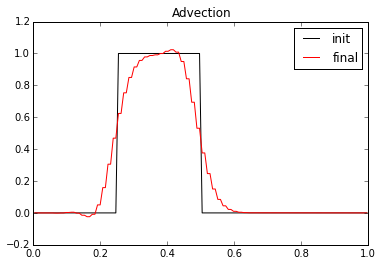

In [5]:
def equilibrium(m0, c):
    return c*m0

def initialize(mesh, c, la):
    m0 = np.zeros(mesh.shape)
    m0[np.logical_and(mesh<0.5, mesh>0.25)] = 1.
    m1 = equilibrium(m0, c)
    f0, f1 = np.empty(m0.shape), np.empty(m0.shape)
    m2f(f0, f1, m0, m1, la)
    return f0, f1, m0, m1

def f2m(f0, f1, m0, m1, la):
    m0[:] = f0 + f1
    m1[:] = la*(f1 - f0)
    
def m2f(f0, f1, m0, m1, la):
    f0[:] = 0.5*(m0-m1/la)
    f1[:] = 0.5*(m0+m1/la)

def relaxation(m0, m1, c, s):
    m1[:] = (1-s)*m1 + s*equilibrium(m0, c)

def transport(f0, f1):
    #periodical boundary conditions
    f0[-1] = f0[1]
    f1[0] = f1[-2]
    #transport
    f0[1:-1] = f0[2:]
    f1[1:-1] = f1[:-2]

# parameters
c = .5  # velocity for the transport equation
Tf = 2. # final time
N = 128 # number of points in space
la = 1. # scheme velocity
s = 1.8 # relaxation parameter
# initialization
x = mesh(N)
f0, f1, m0, m1 = initialize(x, c, la)
t = 0
dt = (x[1]-x[0])/la
plt.figure(1)
plt.clf()
plt.plot(x[1:-1], m0[1:-1], 'k', label='init')
while t<Tf:
    t += dt
    relaxation(m0, m1, c, s)
    m2f(f0, f1, m0, m1, la)
    transport(f0, f1)
    f2m(f0, f1, m0, m1, la)
plt.plot(x[1:-1], m0[1:-1], 'r', label='final')
plt.legend()
plt.title('Advection')
plt.show()

##The Burger's equation

The problem reads
$$\drondt u + \tfrac{1}{2} \drondx u^2 = 0, \quad t>0, \quad x\in(0, 1).$$

The previous $\DdQq{1}{2}$ scheme can simulate the Burger's equation by modifying the equilibrium value of the moment of order $1$ $\mke{1}$. 
It now reads $\mke{1} = {\mk{0}}^2/2$.

More generaly, the simulated equation is into the conservative form
$$\drondt u + \drondx \varphi(u) = 0, \quad t>0, \quad x\in(0, 1),$$
the equilibrium has to be taken to $\mke{1}=\varphi(\mk{0})$.


####Question 1

Modify the previous scripts to simulate the Burger's equation. The initial condition can be a discontinuous function in order to simulate Riemann problems. Note that the function f2m, m2f, relaxation, and transport are unchanged.

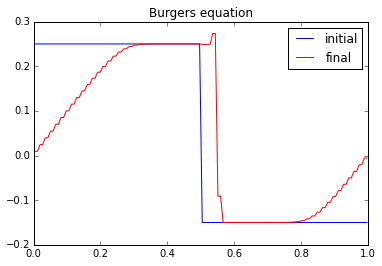

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def mesh(N):
    xmin, xmax = 0., 1.
    dx = 1./N
    x = np.linspace(xmin-.5*dx, xmax+.5*dx, N+2)
    return x

def equilibrium(m0):
    return .5*m0**2

def initialize(mesh, la):
    ug, ud = 0.25, -0.15
    xmin, xmax = .5*np.sum(mesh[:2]), .5*np.sum(mesh[-2:])
    xc = xmin + .5*(xmax-xmin)
    m0 = ug*(mesh<xc) + ud*(mesh>xc) + .5*(ug+ud)*(mesh==xc)
    m1 = equilibrium(m0)
    f0 = np.empty(m0.shape)
    f1 = np.empty(m0.shape)
    return f0, f1, m0, m1

def f2m(f0, f1, m0, m1, la):
    m0[:] = f0 + f1
    m1[:] = la * (f1-f0)

def m2f(f0, f1, m0, m1, la):
    f0[:] = .5 * (m0 - m1/la)
    f1[:] = .5 * (m0 + m1/la)

def relaxation(m0, m1, s):
    m1[:] *= (1-s)
    m1[:] += s*equilibrium(m0)

def transport(f0, f1):
    #periodical boundary conditions
    f0[-1] = f0[1]
    f1[0] = f1[-2]
    # transport
    f0[1:-1] = f0[2:]
    f1[1:-1] = f1[:-2]

# parameters
Tf = 1. # final time
N = 128 # number of points in space
la = 1. # scheme velocity
s = 1.8 # relaxation parameter
# initialization
x = mesh(N)     # mesh
dx = x[1]-x[0]  # space step
dt = dx/la      # time step
f0, f1, m0, m1 = initialize(x, la)
plt.figure(1)
plt.plot(x[1:-1], m0[1:-1], 'b', label='initial')
# time loops
t = 0.
while (t<Tf):
    t += dt
    relaxation(m0, m1, s)
    m2f(f0, f1, m0, m1, la)
    transport(f0, f1)
    f2m(f0, f1, m0, m1, la)
plt.plot(x[1:-1], m0[1:-1], 'r', label='final')
plt.title('Burgers equation')
plt.legend(loc='best')
plt.show()

####Question 2

Test different values of the relaxation parameter $s$. In particular, observe that the scheme remains stable if $s\in[0,2]$. More $s$ is small, more the numerical diffusion is important and if $s$ is close to $2$, oscillations appear behind the shock.

In order to simulate a Riemann problem, the boundary conditions have to be modified. A classical way is to impose entry conditions for hyperbolic problems. The lattice Boltzmann methods lend themselves very well to that conditions: the scheme only needs the distributions corresponding to a velocity that goes inside the domain. Nevertheless, on a physical edge where the flux is going outside, a non physical distribution that goes inside has to be imposed. A first simple way is to leave the initial value: this is correct while the discontinuity does not reach the edge. A second way is to impose Neumann condition by repeating the inner value.

####Question 3

Modify the previous script to take into account these new boundary conditions.


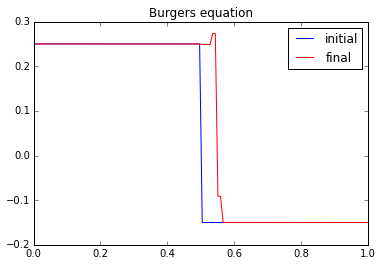

In [4]:
def transport(f0, f1):
    # Neumann boundary conditions
    f0[-1] = f0[-2]
    f1[0] = f1[1]
    # transport
    f0[1:-1] = f0[2:]
    f1[1:-1] = f1[:-2]
    
# parameters
Tf = 1. # final time
N = 128 # number of points in space
la = 1. # scheme velocity
s = 1.8 # relaxation parameter

# initialization
x = mesh(N)     # mesh
dx = x[1]-x[0]  # space step
dt = dx/la      # time step
f0, f1, m0, m1 = initialize(x, la)
plt.figure(1)
plt.plot(x[1:-1], m0[1:-1], 'b', label='initial')
# time loops
t = 0.
while (t<Tf):
    t += dt
    relaxation(m0, m1, s)
    m2f(f0, f1, m0, m1, la)
    transport(f0, f1)
    f2m(f0, f1, m0, m1, la)
plt.plot(x[1:-1], m0[1:-1], 'r', label='final')
plt.title('Burgers equation')
plt.legend(loc='best')
plt.show()

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()